# Comparing Tikhonet and SCORE

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht/'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import pickle

In [2]:
f = open(data_path+"cfht_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [3]:
data.keys(),data['flux'].keys()

(dict_keys(['flux', 'mse', 'mse_w', 'mom', 'windows', 'window_flags', 'mag_auto']),
 dict_keys(['sparsity', 'score', 'tikhonet', 'tikhonet_sc', 'true']))

### Load data and compute errors

In [4]:
# load windows and flags
windows = data['windows']
window_flags = data['window_flags']

# load adaptive moments
mom_g0 = data['mom']['tikhonet']
mom_s0 = data['mom']['sparsity']
mom_s1 = data['mom']['score']
mom_g05 = data['mom']['tikhonet_sc']
mom_hst = data['mom']['true']

# load flux
flux_g0 = data['flux']['tikhonet']
flux_s0 = data['flux']['sparsity']
flux_s1 = data['flux']['score']
flux_g05 = data['flux']['tikhonet_sc']
flux_true = data['flux']['true']

# compute relative pixel errors
mse_g0 = data['mse']['tikhonet']
mse_s0 = data['mse']['sparsity']
mse_s1 = data['mse']['score']
mse_g05 = data['mse']['tikhonet_sc']

# compute winodwed pixel relative errors
mse_g0_w = data['mse_w']['tikhonet']
mse_s0_w = data['mse_w']['sparsity']
mse_s1_w = data['mse_w']['score']
mse_g05_w = data['mse_w']['tikhonet_sc']

# compute adapative moments errors
mom_err_g0 = mom_g0-mom_hst
mom_err_s0 = mom_s0-mom_hst
mom_err_s1 = mom_s1-mom_hst
mom_err_g05 = mom_g05-mom_hst

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true
flux_err_s0 = np.abs(flux_s0 - flux_true) / flux_true
flux_err_s1 = np.abs(flux_s1 - flux_true) /flux_true

### Compute Errors per Bin

In [5]:
label_s0 = r'Sparsity'
label_s1 = r'SCORE'
label_g0 = r'Tikhonet'
label_g05 = r'Tikhonet + MW'

color_g0 = 'green'
color_g05 = 'darkgreen'
color_s0 = 'blue'
color_s1 = 'darkblue'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [6]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [9]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_s1_win = mse_s1[window_flags]
mse_s0_win = mse_s0[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_s1_win_w = mse_s1_w[window_flags]
mse_s0_win_w = mse_s0_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_s1_win = mom_err_s1[:,window_flags]
mom_err_s0_win = mom_err_s0[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute fluxipticity errors
flux_err_g0_win = flux_err_g0[window_flags]
flux_err_s1_win = flux_err_s1[window_flags]
flux_err_s0_win = flux_err_s0[window_flags]
flux_err_g05_win = flux_err_g05[window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(data['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_s1 = []
mom_mean_s0 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_s1 = []
mom_std_s0 = []
mom_std_g05 = []

# computing mean and standard deviation of fluxipticity error per binned magnitude

flux_mean_g0 = []
flux_mean_s1 = []
flux_mean_s0 = []
flux_mean_g05 = []

flux_std_g0 = []
flux_std_s1 = []
flux_std_s0 = []
flux_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_s1 = []
mse_mean_s0 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_s1 = []
mse_std_s0 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_s1_w = []
mse_mean_s0_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_s1_w = []
mse_std_s0_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(data['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
    flux_mean_s1 += [np.mean(np.abs(flux_err_s1_win[ind]))]
    flux_mean_s0 += [np.mean(np.abs(flux_err_s0_win[ind]))]
    flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]

    flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
    flux_std_s1 += [np.std(np.abs(flux_err_s1_win[ind]))]
    flux_std_s0 += [np.std(np.abs(flux_err_s0_win[ind]))]
    flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_s1 += [np.mean(mse_s1_win[ind])]
    mse_mean_s0 += [np.mean(mse_s0_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_s1 += [np.std(mse_s1_win[ind])]
    mse_std_s0 += [np.std(mse_s0_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
    mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
    mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=data['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
flux_mean_s1 += [np.mean(np.abs(flux_err_s1_win[ind]))]
flux_mean_s0 += [np.mean(np.abs(flux_err_s0_win[ind]))]
flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]

flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
flux_std_s1 += [np.std(np.abs(flux_err_s1_win[ind]))]
flux_std_s0 += [np.std(np.abs(flux_err_s0_win[ind]))]
flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_s1 += [np.mean(mse_s1_win[ind])]
mse_mean_s0 += [np.mean(mse_s0_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_s1 += [np.std(mse_s1_win[ind])]
mse_std_s0 += [np.std(mse_s0_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_s1 = np.array(mom_mean_s1).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_s1 = np.array(mom_std_s1).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_g05 = np.array(mom_std_g05).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_s1 = np.array(flux_mean_s1).T
flux_mean_s0 = np.array(flux_mean_s0).T
flux_mean_g05 = np.array(flux_mean_g05).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_s1 = np.array(flux_std_s1).T
flux_std_s0 = np.array(flux_std_s0).T
flux_std_g05 = np.array(flux_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_s1 = np.array(mse_mean_s1).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_s1 = np.array(mse_std_s1).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_s1_w = np.array(mse_mean_s1_w).T
mse_mean_s0_w = np.array(mse_mean_s0_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_s1_w = np.array(mse_std_s1_w).T
mse_std_s0_w = np.array(mse_std_s0_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [10]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(data['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = data['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=data['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = data['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot relative flux vs $\text{MAG}$

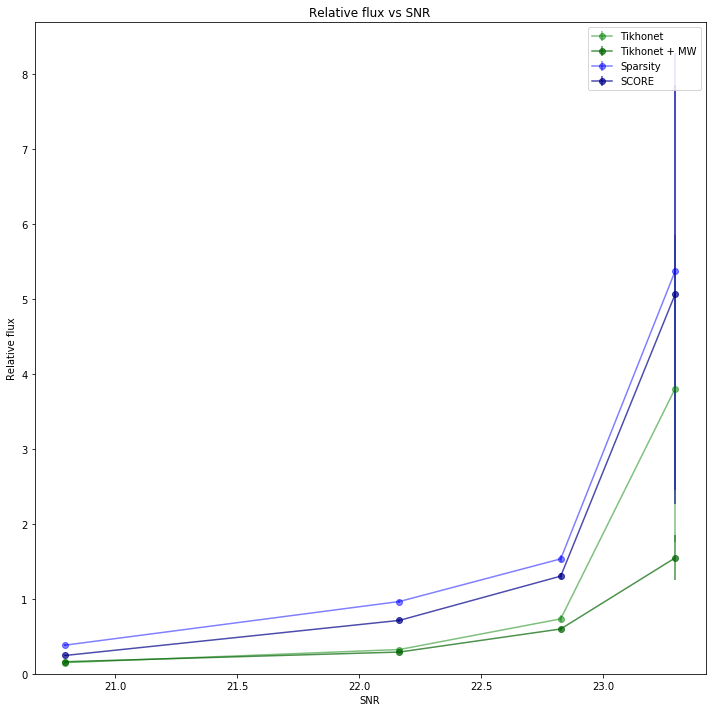

In [11]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,flux_mean_s0,flux_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,flux_mean_s1,flux_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ylim(bottom=0)
plt.xlabel(r'SNR')
plt.ylabel(r'Relative flux')
plt.title(r'Relative flux vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $g$ vs $\text{MAG}$

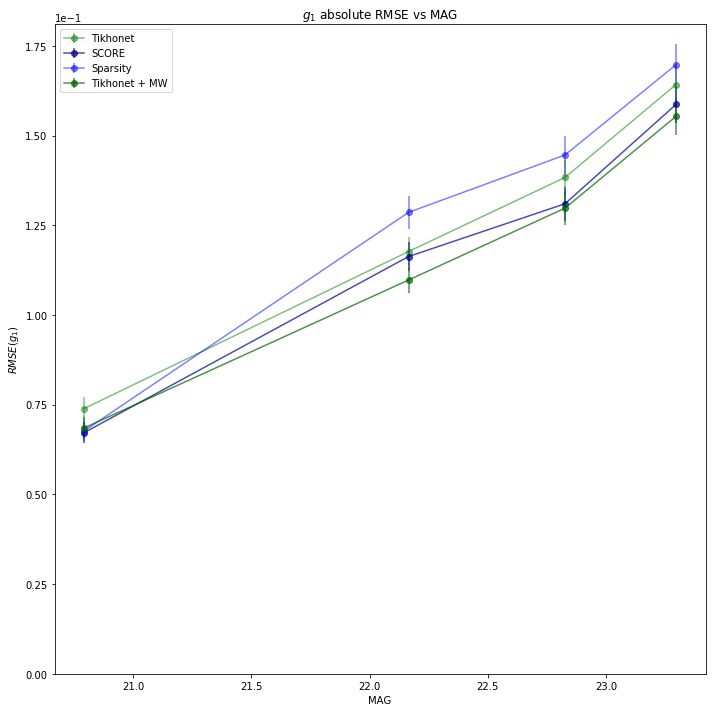

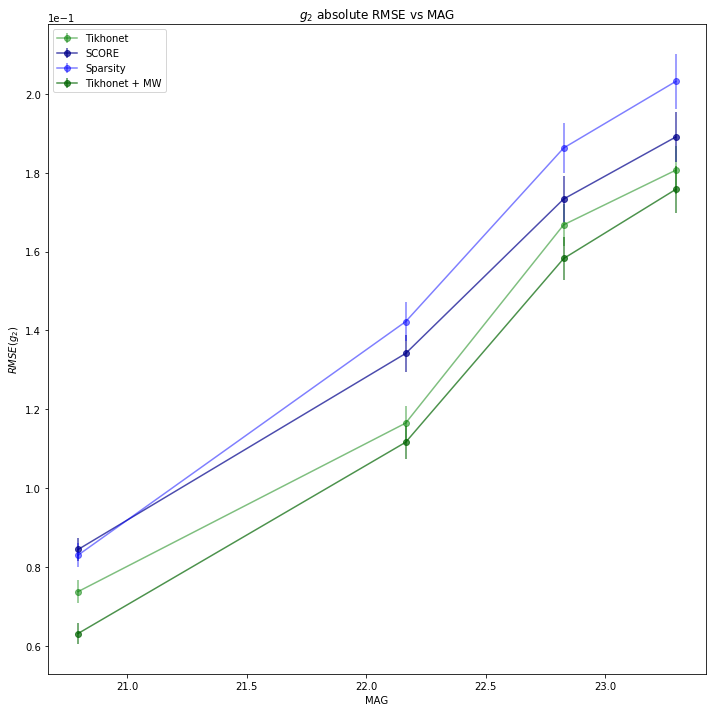

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $\text{MSE}$ vs $\text{MAG}$

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


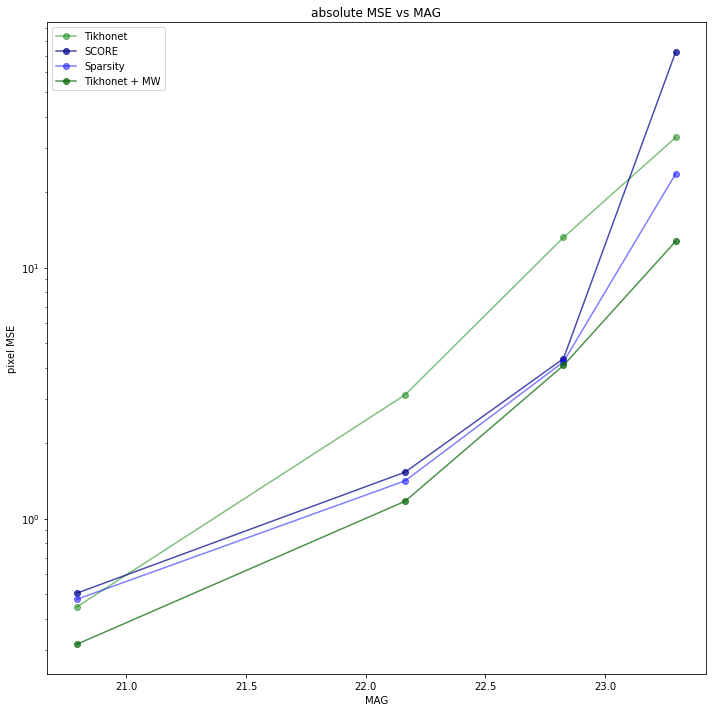

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


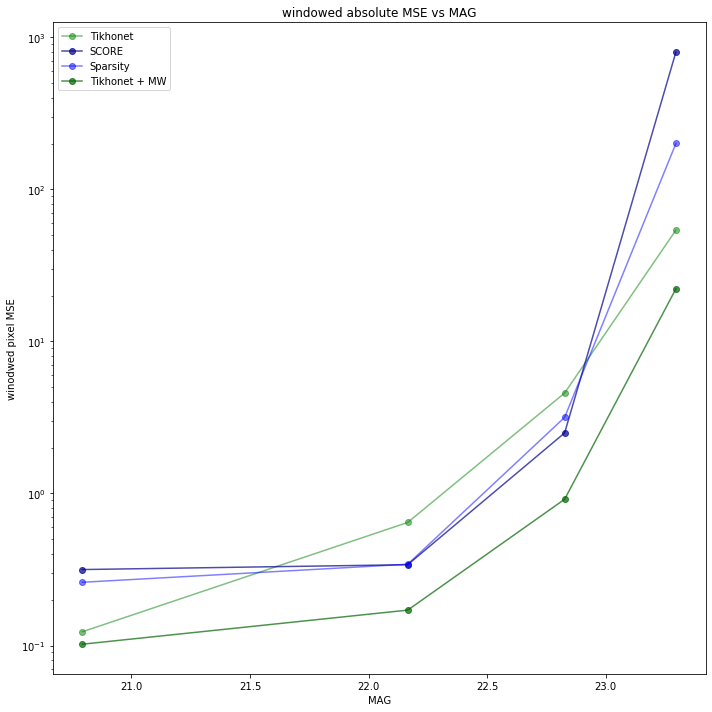

In [13]:
plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1,mse_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.errorbar(bins,mse_mean_s0,mse_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.semilogy(bins,mse_mean_s0,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1_w,mse_std_s1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.errorbar(bins,mse_mean_s0_w,mse_std_s0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1_w,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.semilogy(bins,mse_mean_s0_w,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()